In [8]:
# The situation is that suppose we get the complexity ratio for different classes
# and now we want to find the smallest n such that
# when the number of paramters of the network goes to infinity
# we have that the model accuarcy is smaller than some epsilon > 0.
# Firstly, we create a large enough network:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InvariantNet(nn.Module):

    def __init__(self, n=100):
        super(InvariantNet, self).__init__()
        self.n = n

        # Fully connected layers
        self.fc1 = nn.Linear(self.n, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 40)
        self.fc4 = nn.Linear(40, 10)

        # BatchNorm layers for the 3 hidden layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(40)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [9]:
from torchinfo import summary

model = InvariantNet(n=100)
summary(model, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
InvariantNet                             [1, 10]                   --
├─Linear: 1-1                            [1, 64]                   6,464
├─BatchNorm1d: 1-2                       [1, 64]                   128
├─Dropout: 1-3                           [1, 64]                   --
├─Linear: 1-4                            [1, 64]                   4,160
├─BatchNorm1d: 1-5                       [1, 64]                   128
├─Dropout: 1-6                           [1, 64]                   --
├─Linear: 1-7                            [1, 40]                   2,600
├─BatchNorm1d: 1-8                       [1, 40]                   80
├─Dropout: 1-9                           [1, 40]                   --
├─Linear: 1-10                           [1, 10]                   410
Total params: 13,970
Trainable params: 13,970
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass siz

In [4]:
import json
from combinedlist_selected import proportional_random_sample
from sklearn.datasets import load_digits
from eval import invariants_eval_combined_list
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from layer import InvariantNet

Key=5: It has 299 elements, aim to select 0 elements, actually select 0 elements
Key=2: It has 307 elements, aim to select 1 elements, actually select 1 elements
Key=8: It has 817 elements, aim to select 2 elements, actually select 2 elements
Key=7: It has 377 elements, aim to select 1 elements, actually select 1 elements
Key=4: It has 409 elements, aim to select 1 elements, actually select 1 elements
Key=3: It has 444 elements, aim to select 1 elements, actually select 1 elements
Key=0: It has 951 elements, aim to select 2 elements, actually select 2 elements
Key=9: It has 484 elements, aim to select 1 elements, actually select 1 elements
Key=6: It has 517 elements, aim to select 1 elements, actually select 1 elements
Key=1: It has 146 elements, aim to select 0 elements, actually select 0 elements
n=10 Epoch 1/64, Loss: 2.3871
n=10 Epoch 2/64, Loss: 2.2658
n=10 Epoch 3/64, Loss: 2.2080
n=10 Epoch 4/64, Loss: 2.1654
n=10 Epoch 5/64, Loss: 2.1291
n=10 Epoch 6/64, Loss: 2.0802
n=10 Epoch

C:\Users\miaoj\AppData\Local\Temp\ipykernel_110168\1934801770.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


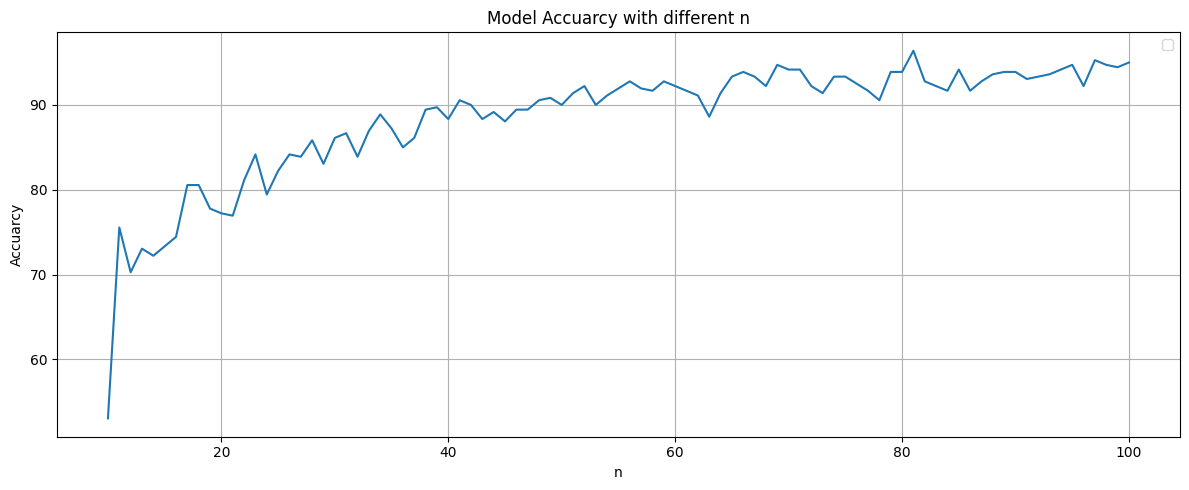

In [26]:
n_list = [n for n in range(10, 101)]
acc_list = []

for n in n_list:

    json_file_path = "stored_data/combined_dict.json"

    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    combined_list = proportional_random_sample(data, n)
    digits = load_digits()
    aux_X = digits.images  # (1797, 8, 8)
    X = invariants_eval_combined_list(aux_X, combined_list)
    y = digits.target 

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = InvariantNet(n)
    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"n={n} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    acc_list.append(accuracy)
    print(f"n={n} Test Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(12, 5))

plt.plot(n_list, acc_list)
plt.title('Model Accuarcy with different n')
plt.xlabel('n')
plt.ylabel('Accuarcy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Hence, we conclude that when n >= 80, the model reaches its max learnable accuarcy. This means if we select more than 80 invariants, then the model is learnable from these 80 invariants. For the further investigation, we consider the case n = 100.

In [10]:
class InvariantNet_variant(nn.Module):

    def __init__(self, n=100, k=64):
        super(InvariantNet_variant, self).__init__()
        self.n = n
        self.k = k

        # Fully connected layers
        self.fc1 = nn.Linear(self.n, k)
        self.fc2 = nn.Linear(k, k)
        self.fc3 = nn.Linear(k, k)
        self.fc4 = nn.Linear(k, 10)

        # BatchNorm layers for the 3 hidden layers
        self.bn1 = nn.BatchNorm1d(k)
        self.bn2 = nn.BatchNorm1d(k)
        self.bn3 = nn.BatchNorm1d(k)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
from torchinfo import summary

model = InvariantNet_variant(n=300, k=220)
summary(model, input_size=(1, 300))

Layer (type:depth-idx)                   Output Shape              Param #
InvariantNet_variant                     [1, 10]                   --
├─Linear: 1-1                            [1, 220]                  66,220
├─BatchNorm1d: 1-2                       [1, 220]                  440
├─Dropout: 1-3                           [1, 220]                  --
├─Linear: 1-4                            [1, 220]                  48,620
├─BatchNorm1d: 1-5                       [1, 220]                  440
├─Dropout: 1-6                           [1, 220]                  --
├─Linear: 1-7                            [1, 220]                  48,620
├─BatchNorm1d: 1-8                       [1, 220]                  440
├─Dropout: 1-9                           [1, 220]                  --
├─Linear: 1-10                           [1, 10]                   2,210
Total params: 166,990
Trainable params: 166,990
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward 

In [25]:
k_list = [k for k in range(32, 257, 5)]
parameters_list = []
acc_list = []

for k in k_list:

    digits = load_digits()
    X = torch.load("stored_data/invariants_selected_100.pt")
    y = digits.target 

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = InvariantNet_variant(n=100, k=k)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters_list.append(total_params)

    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"k={k} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    acc_list.append(accuracy)
    print(f"k={k} Test Accuracy: {accuracy:.2f}%")

    with open('stored_data/results_100.txt', 'w') as f:
        for p, a in zip(parameters_list, acc_list):
            f.write(f"{p},{a}\n")

C:\Users\miaoj\AppData\Local\Temp\ipykernel_122108\4176535355.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("stored_data/invariants_selected_100.pt")


k=32 Epoch 1/64, Loss: 2.3504
k=32 Epoch 2/64, Loss: 2.2635
k=32 Epoch 3/64, Loss: 2.1705
k=32 Epoch 4/64, Loss: 2.0872
k=32 Epoch 5/64, Loss: 2.0295
k=32 Epoch 6/64, Loss: 1.9547
k=32 Epoch 7/64, Loss: 1.8952
k=32 Epoch 8/64, Loss: 1.8501
k=32 Epoch 9/64, Loss: 1.8314
k=32 Epoch 10/64, Loss: 1.7774
k=32 Epoch 11/64, Loss: 1.7199
k=32 Epoch 12/64, Loss: 1.7269
k=32 Epoch 13/64, Loss: 1.6369
k=32 Epoch 14/64, Loss: 1.6299
k=32 Epoch 15/64, Loss: 1.5653
k=32 Epoch 16/64, Loss: 1.5633
k=32 Epoch 17/64, Loss: 1.5257
k=32 Epoch 18/64, Loss: 1.4973
k=32 Epoch 19/64, Loss: 1.4832
k=32 Epoch 20/64, Loss: 1.4455
k=32 Epoch 21/64, Loss: 1.3999
k=32 Epoch 22/64, Loss: 1.3872
k=32 Epoch 23/64, Loss: 1.3119
k=32 Epoch 24/64, Loss: 1.3383
k=32 Epoch 25/64, Loss: 1.3217
k=32 Epoch 26/64, Loss: 1.3195
k=32 Epoch 27/64, Loss: 1.2596
k=32 Epoch 28/64, Loss: 1.2655
k=32 Epoch 29/64, Loss: 1.2710
k=32 Epoch 30/64, Loss: 1.2277
k=32 Epoch 31/64, Loss: 1.2124
k=32 Epoch 32/64, Loss: 1.2039
k=32 Epoch 33/64,

C:\Users\miaoj\AppData\Local\Temp\ipykernel_122108\4265280093.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


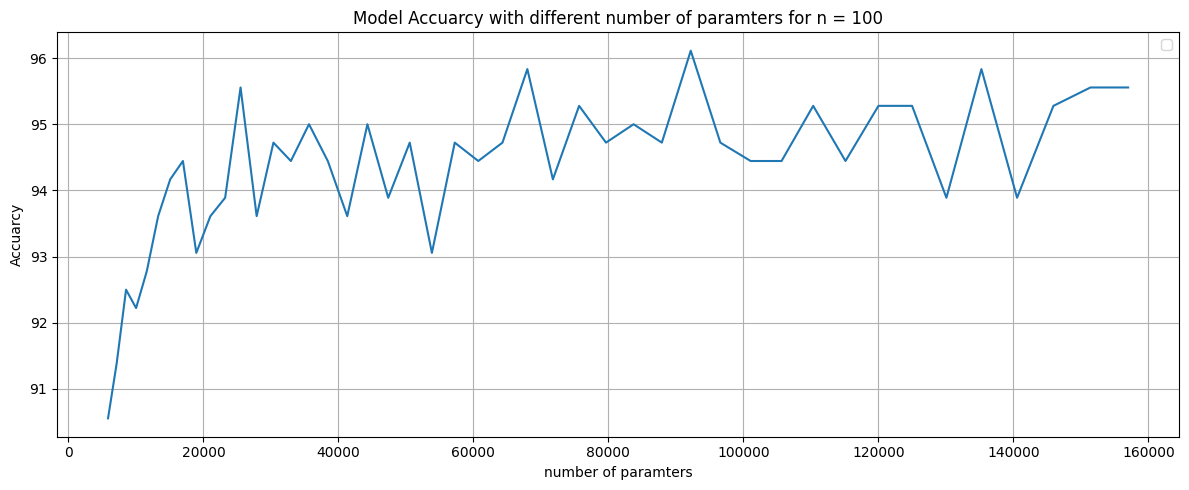

In [26]:
plt.figure(figsize=(12, 5))

plt.plot(parameters_list, acc_list)
plt.title('Model Accuarcy with different number of paramters for n = 100')
plt.xlabel('number of paramters')
plt.ylabel('Accuarcy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [38]:
k_list = [k for k in range(25, 240, 5)]
parameters_list = []
acc_list = []

json_file_path = "stored_data/combined_dict.json"

with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

combined_list = proportional_random_sample(data, 200)

digits = load_digits()
aux_X = digits.images  # (1797, 8, 8)
X = invariants_eval_combined_list(aux_X, combined_list)
y = digits.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:

    # Initialize model
    model = InvariantNet_variant(n=200, k=k)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters_list.append(total_params)

    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"k={k} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    acc_list.append(accuracy)
    print(f"k={k} Test Accuracy: {accuracy:.2f}%")

    with open('stored_data/results_200.txt', 'w') as f:
        for p, a in zip(parameters_list, acc_list):
            f.write(f"{p},{a}\n")

Key=0: It has 951 elements, aim to select 40 elements, actually select 40 elements
Key=1: It has 146 elements, aim to select 6 elements, actually select 6 elements
Key=2: It has 307 elements, aim to select 13 elements, actually select 13 elements
Key=3: It has 444 elements, aim to select 19 elements, actually select 19 elements
Key=4: It has 409 elements, aim to select 17 elements, actually select 17 elements
Key=5: It has 299 elements, aim to select 13 elements, actually select 13 elements
Key=6: It has 517 elements, aim to select 22 elements, actually select 22 elements
Key=7: It has 377 elements, aim to select 16 elements, actually select 16 elements
Key=8: It has 817 elements, aim to select 34 elements, actually select 34 elements
Key=9: It has 484 elements, aim to select 20 elements, actually select 20 elements
k=25 Epoch 1/64, Loss: 2.3450
k=25 Epoch 2/64, Loss: 2.2161
k=25 Epoch 3/64, Loss: 2.1448
k=25 Epoch 4/64, Loss: 2.0893
k=25 Epoch 5/64, Loss: 2.0227
k=25 Epoch 6/64, Loss:

C:\Users\miaoj\AppData\Local\Temp\ipykernel_122108\1799582872.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


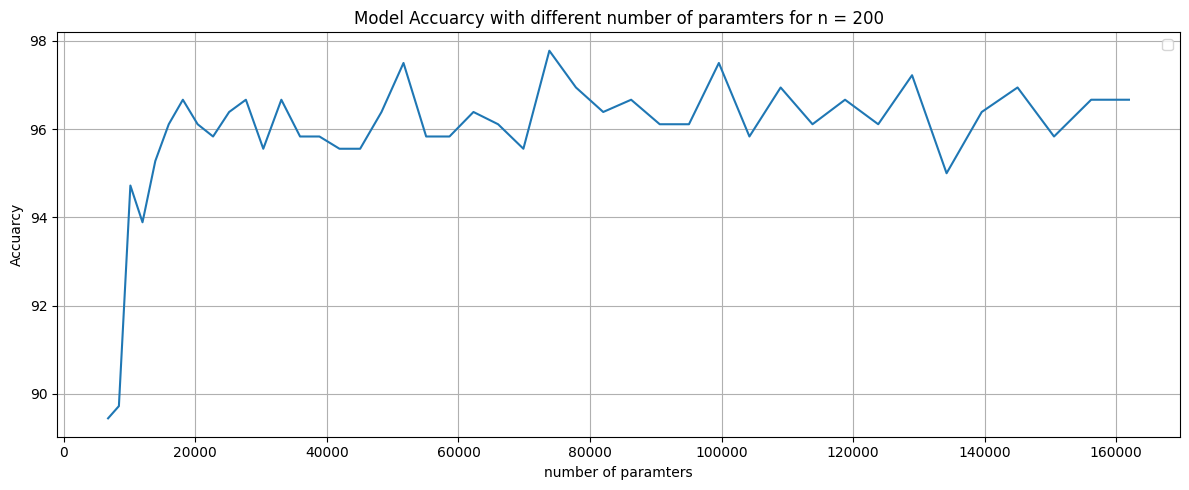

In [40]:
plt.figure(figsize=(12, 5))

plt.plot(parameters_list, acc_list)
plt.title('Model Accuarcy with different number of paramters for n = 200')
plt.xlabel('number of paramters')
plt.ylabel('Accuarcy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [47]:
k_list = [k for k in range(18, 220, 5)]
parameters_list = []
acc_list = []

json_file_path = "stored_data/combined_dict.json"

with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

combined_list = proportional_random_sample(data, 300)

digits = load_digits()
aux_X = digits.images  # (1797, 8, 8)
X = invariants_eval_combined_list(aux_X, combined_list)
y = digits.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:

    # Initialize model
    model = InvariantNet_variant(n=300, k=k)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters_list.append(total_params)

    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"k={k} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    acc_list.append(accuracy)
    print(f"k={k} Test Accuracy: {accuracy:.2f}%")

    with open('stored_data/results_300.txt', 'w') as f:
        for p, a in zip(parameters_list, acc_list):
            f.write(f"{p},{a}\n")

Key=9: It has 484 elements, aim to select 30 elements, actually select 30 elements
Key=8: It has 817 elements, aim to select 52 elements, actually select 52 elements
Key=6: It has 517 elements, aim to select 33 elements, actually select 33 elements
Key=7: It has 377 elements, aim to select 24 elements, actually select 24 elements
Key=4: It has 409 elements, aim to select 26 elements, actually select 26 elements
Key=5: It has 299 elements, aim to select 19 elements, actually select 19 elements
Key=3: It has 444 elements, aim to select 28 elements, actually select 28 elements
Key=0: It has 951 elements, aim to select 60 elements, actually select 60 elements
Key=1: It has 146 elements, aim to select 9 elements, actually select 9 elements
Key=2: It has 307 elements, aim to select 19 elements, actually select 19 elements
k=18 Epoch 1/64, Loss: 2.4049
k=18 Epoch 2/64, Loss: 2.2673
k=18 Epoch 3/64, Loss: 2.2087
k=18 Epoch 4/64, Loss: 2.1354
k=18 Epoch 5/64, Loss: 2.1042
k=18 Epoch 6/64, Loss:

C:\Users\miaoj\AppData\Local\Temp\ipykernel_122108\3786899372.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


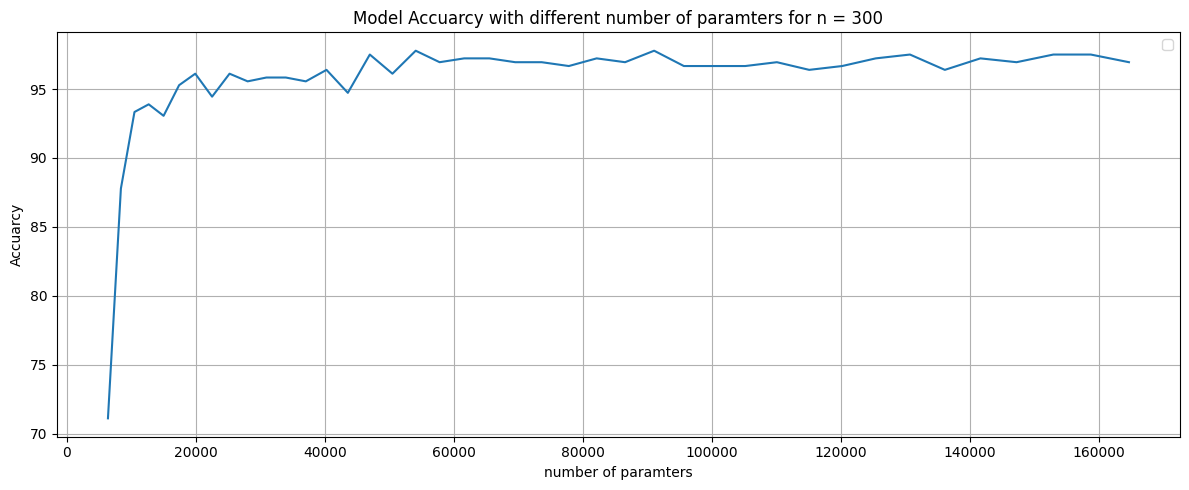

In [48]:
plt.figure(figsize=(12, 5))

plt.plot(parameters_list, acc_list)
plt.title('Model Accuarcy with different number of paramters for n = 300')
plt.xlabel('number of paramters')
plt.ylabel('Accuarcy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

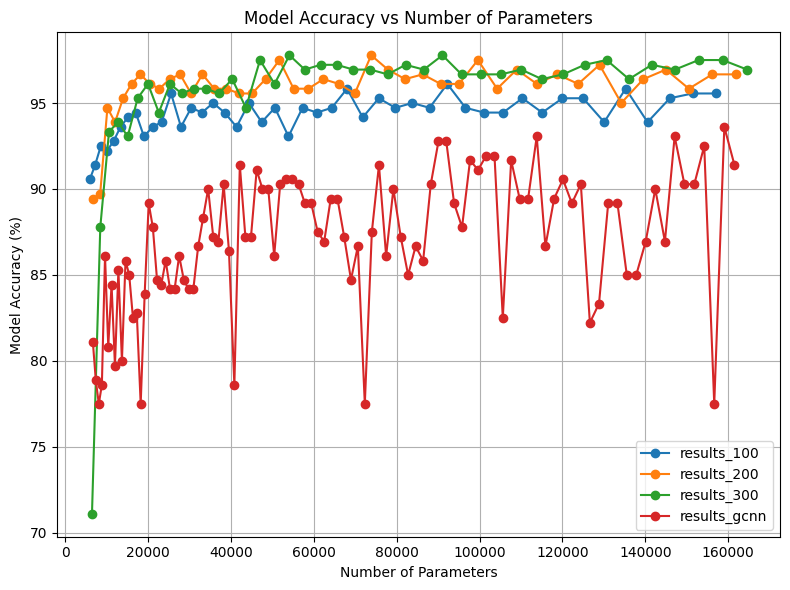

In [50]:
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt

zip_path = 'stored_data/results.zip'

dfs = {}
with zipfile.ZipFile(zip_path, 'r') as z:
    for fname in z.namelist():
        if fname.endswith('/'):
            continue
        content = z.read(fname).decode('utf-8')
        df = pd.read_csv(io.StringIO(content),
                         header=None,
                         names=['params', 'accuracy'])
        label = fname.rsplit('.', 1)[0]
        dfs[label] = df

plt.figure(figsize=(8, 6))
for label, df in dfs.items():
    plt.plot(df['params'],
             df['accuracy'],
             marker='o',
             linestyle='-',
             label=label)

plt.xlabel('Number of Parameters')
plt.ylabel('Model Accuracy (%)')
plt.title('Model Accuracy vs Number of Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
import torch
from sklearn.datasets import load_digits
from layer import InvariantNet
import torchvision.transforms as transforms
from eval import invariants_eval_combined_list

In [13]:
k_list = [k for k in range(32, 257, 5)]
parameters_list = []
acc_list = []

digits = load_digits()
X = torch.load("stored_data/invariants_selected_100.pt")
y = digits.target 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

aux_X = torch.tensor(digits.images, dtype=torch.float32)
aux_y = torch.tensor(digits.target, dtype=torch.long)

# Apply transformations
random_rotate = transforms.RandomRotation(degrees=(0, 360))
X_rotated = torch.stack([random_rotate(img.unsqueeze(0)).squeeze(0) for img in aux_X])

# Convert back to original data type if needed
X_rotated = X_rotated.to(torch.double)

combined_list = []
with open("stored_data/new_combined_list_100.txt", "r") as f:
   for line in f:
    combined_list.append(line.strip())

# invariants = invariants_eval_combined_list(X, combined_list)
X_rotated = invariants_eval_combined_list(X_rotated, combined_list)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:

    # Initialize model
    model = InvariantNet_variant(n=100, k=k)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters_list.append(total_params)

    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"k={k} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    X_rotated = X_rotated.to(device)
    aux_y = aux_y.to(device)

    with torch.no_grad():
        outputs = model(X_rotated)
        _, predicted = torch.max(outputs, 1)
        total = aux_y.size(0)
        correct = (predicted == aux_y).sum().item()
        accuracy = correct / total * 100
        acc_list.append(accuracy)

    with open('stored_data/results_random_100.txt', 'w') as f:
        for p, a in zip(parameters_list, acc_list):
            f.write(f"{p},{a}\n")

C:\Users\miaoj\AppData\Local\Temp\ipykernel_110168\397138621.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("stored_data/invariants_selected_100.pt")


k=32 Epoch 1/64, Loss: 2.3831
k=32 Epoch 2/64, Loss: 2.2684
k=32 Epoch 3/64, Loss: 2.1844
k=32 Epoch 4/64, Loss: 2.0985
k=32 Epoch 5/64, Loss: 2.0223
k=32 Epoch 6/64, Loss: 1.9331
k=32 Epoch 7/64, Loss: 1.8851
k=32 Epoch 8/64, Loss: 1.8385
k=32 Epoch 9/64, Loss: 1.7787
k=32 Epoch 10/64, Loss: 1.7086
k=32 Epoch 11/64, Loss: 1.6926
k=32 Epoch 12/64, Loss: 1.6208
k=32 Epoch 13/64, Loss: 1.5989
k=32 Epoch 14/64, Loss: 1.5587
k=32 Epoch 15/64, Loss: 1.5088
k=32 Epoch 16/64, Loss: 1.4754
k=32 Epoch 17/64, Loss: 1.4754
k=32 Epoch 18/64, Loss: 1.4164
k=32 Epoch 19/64, Loss: 1.3949
k=32 Epoch 20/64, Loss: 1.3759
k=32 Epoch 21/64, Loss: 1.3365
k=32 Epoch 22/64, Loss: 1.3188
k=32 Epoch 23/64, Loss: 1.2907
k=32 Epoch 24/64, Loss: 1.2813
k=32 Epoch 25/64, Loss: 1.2624
k=32 Epoch 26/64, Loss: 1.2628
k=32 Epoch 27/64, Loss: 1.2278
k=32 Epoch 28/64, Loss: 1.2371
k=32 Epoch 29/64, Loss: 1.1351
k=32 Epoch 30/64, Loss: 1.2235
k=32 Epoch 31/64, Loss: 1.2031
k=32 Epoch 32/64, Loss: 1.1799
k=32 Epoch 33/64,

C:\Users\miaoj\AppData\Local\Temp\ipykernel_110168\4085086353.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


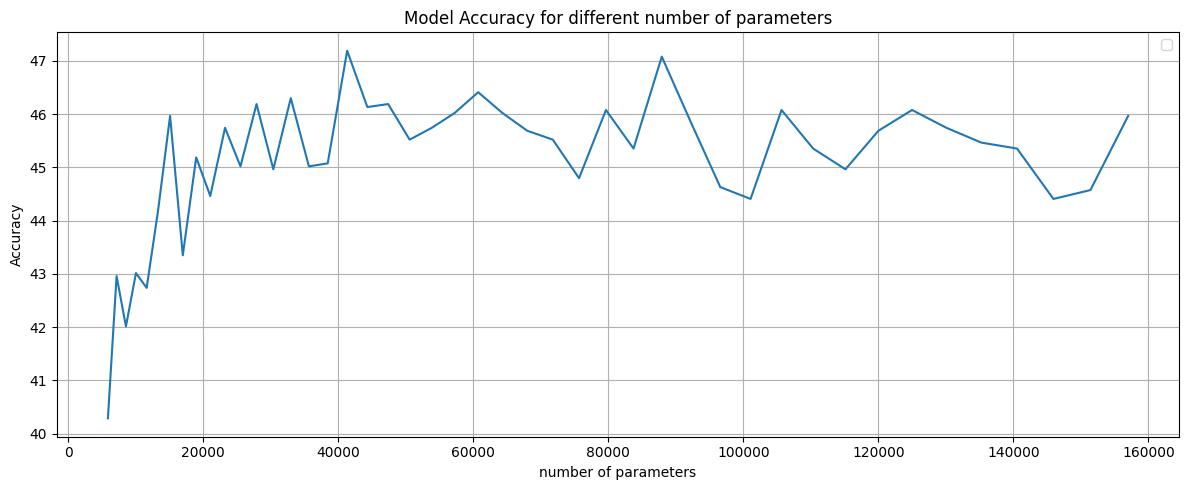

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(parameters_list, acc_list)
plt.xlabel('number of parameters')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for different number of parameters n=100')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [21]:
k_list = [k for k in range(25, 240, 5)]
parameters_list = []
acc_list = []

json_file_path = "stored_data/combined_dict.json"

with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

combined_list = proportional_random_sample(data, 200)

digits = load_digits()
aux_X = digits.images  # (1797, 8, 8)
X = invariants_eval_combined_list(aux_X, combined_list)
y = digits.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

auxaux_X = torch.tensor(digits.images, dtype=torch.float32)
aux_y = torch.tensor(digits.target, dtype=torch.long)

# Apply transformations
random_rotate = transforms.RandomRotation(degrees=(0, 360))
X_rotated = torch.stack([random_rotate(img.unsqueeze(0)).squeeze(0) for img in auxaux_X])

# Convert back to original data type if needed
X_rotated = X_rotated.to(torch.double)

# invariants = invariants_eval_combined_list(X, combined_list)
X_rotated = invariants_eval_combined_list(X_rotated, combined_list)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:

    # Initialize model
    model = InvariantNet_variant(n=200, k=k)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters_list.append(total_params)

    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"k={k} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    X_rotated = X_rotated.to(device)
    aux_y = aux_y.to(device)

    with torch.no_grad():
        outputs = model(X_rotated)
        _, predicted = torch.max(outputs, 1)
        total = aux_y.size(0)
        correct = (predicted == aux_y).sum().item()
        accuracy = correct / total * 100
        acc_list.append(accuracy)

    with open('stored_data/results_random_200.txt', 'w') as f:
        for p, a in zip(parameters_list, acc_list):
            f.write(f"{p},{a}\n")

Key=0: It has 951 elements, aim to select 40 elements, actually select 40 elements
Key=1: It has 146 elements, aim to select 6 elements, actually select 6 elements
Key=2: It has 307 elements, aim to select 13 elements, actually select 13 elements
Key=3: It has 444 elements, aim to select 19 elements, actually select 19 elements
Key=4: It has 409 elements, aim to select 17 elements, actually select 17 elements
Key=5: It has 299 elements, aim to select 13 elements, actually select 13 elements
Key=6: It has 517 elements, aim to select 22 elements, actually select 22 elements
Key=7: It has 377 elements, aim to select 16 elements, actually select 16 elements
Key=8: It has 817 elements, aim to select 34 elements, actually select 34 elements
Key=9: It has 484 elements, aim to select 20 elements, actually select 20 elements
k=25 Epoch 1/64, Loss: 2.3503
k=25 Epoch 2/64, Loss: 2.1953
k=25 Epoch 3/64, Loss: 2.1280
k=25 Epoch 4/64, Loss: 2.0518
k=25 Epoch 5/64, Loss: 2.0161
k=25 Epoch 6/64, Loss:

C:\Users\miaoj\AppData\Local\Temp\ipykernel_110168\377294402.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


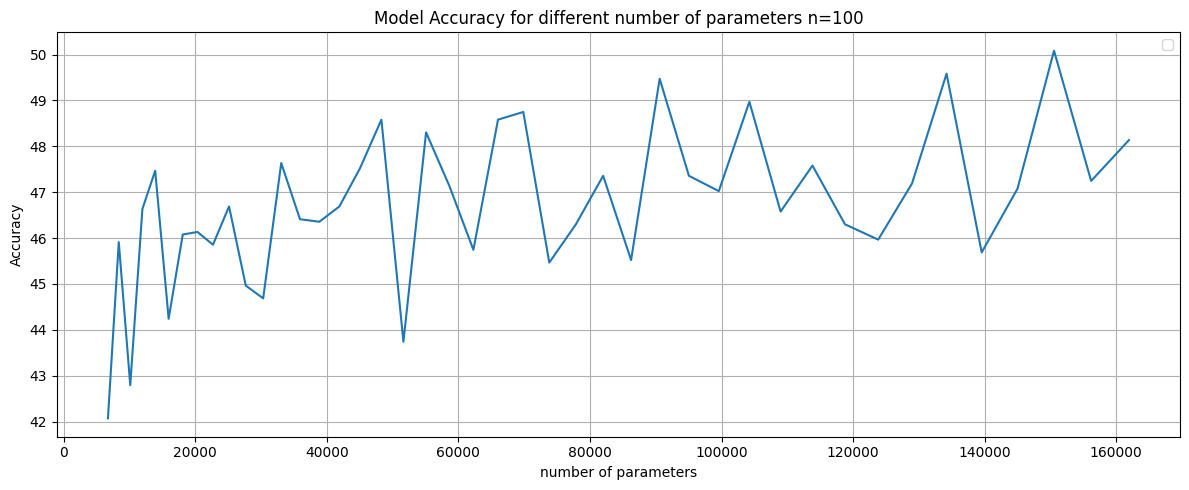

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(parameters_list, acc_list)
plt.xlabel('number of parameters')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for different number of parameters n=100')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
k_list = [k for k in range(18, 220, 5)]
parameters_list = []
acc_list = []

json_file_path = "stored_data/combined_dict.json"

with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

combined_list = proportional_random_sample(data, 300)

digits = load_digits()
aux_X = digits.images  # (1797, 8, 8)
X = invariants_eval_combined_list(aux_X, combined_list)
y = digits.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

auxaux_X = torch.tensor(digits.images, dtype=torch.float32)
aux_y = torch.tensor(digits.target, dtype=torch.long)

# Apply transformations
random_rotate = transforms.RandomRotation(degrees=(0, 360))
X_rotated = torch.stack([random_rotate(img.unsqueeze(0)).squeeze(0) for img in auxaux_X])

# Convert back to original data type if needed
X_rotated = X_rotated.to(torch.double)

# invariants = invariants_eval_combined_list(X, combined_list)
X_rotated = invariants_eval_combined_list(X_rotated, combined_list)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for k in k_list:

    # Initialize model
    model = InvariantNet_variant(n=300, k=k)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters_list.append(total_params)

    model = model.double()
    network = model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    # Training params
    epochs = 64

    # Training loop
    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float64)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = network(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"k={k} Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    network.eval()
    X_rotated = X_rotated.to(device)
    aux_y = aux_y.to(device)

    with torch.no_grad():
        outputs = model(X_rotated)
        _, predicted = torch.max(outputs, 1)
        total = aux_y.size(0)
        correct = (predicted == aux_y).sum().item()
        accuracy = correct / total * 100
        acc_list.append(accuracy)

    with open('stored_data/results_random_300.txt', 'w') as f:
        for p, a in zip(parameters_list, acc_list):
            f.write(f"{p},{a}\n")

Key=9: It has 484 elements, aim to select 30 elements, actually select 30 elements
Key=8: It has 817 elements, aim to select 52 elements, actually select 52 elements
Key=6: It has 517 elements, aim to select 33 elements, actually select 33 elements
Key=7: It has 377 elements, aim to select 24 elements, actually select 24 elements
Key=4: It has 409 elements, aim to select 26 elements, actually select 26 elements
Key=5: It has 299 elements, aim to select 19 elements, actually select 19 elements
Key=3: It has 444 elements, aim to select 28 elements, actually select 28 elements
Key=0: It has 951 elements, aim to select 60 elements, actually select 60 elements
Key=1: It has 146 elements, aim to select 9 elements, actually select 9 elements
Key=2: It has 307 elements, aim to select 19 elements, actually select 19 elements
k=18 Epoch 1/64, Loss: 2.4093
k=18 Epoch 2/64, Loss: 2.3090
k=18 Epoch 3/64, Loss: 2.2448
k=18 Epoch 4/64, Loss: 2.1980
k=18 Epoch 5/64, Loss: 2.1565
k=18 Epoch 6/64, Loss:

C:\Users\miaoj\AppData\Local\Temp\ipykernel_110168\377294402.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


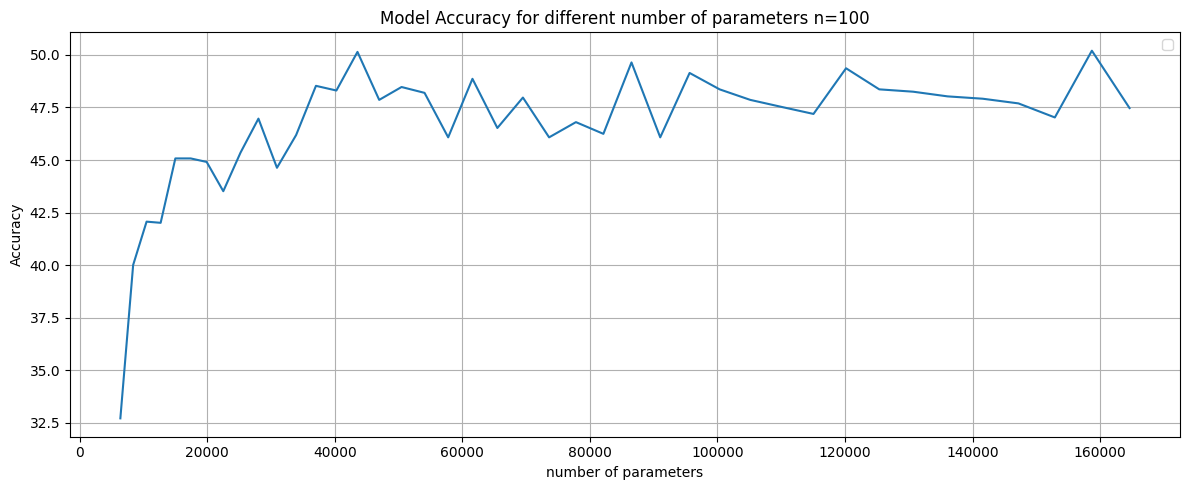

In [24]:
plt.figure(figsize=(12, 5))

plt.plot(parameters_list, acc_list)
plt.xlabel('number of parameters')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for different number of parameters n=100')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

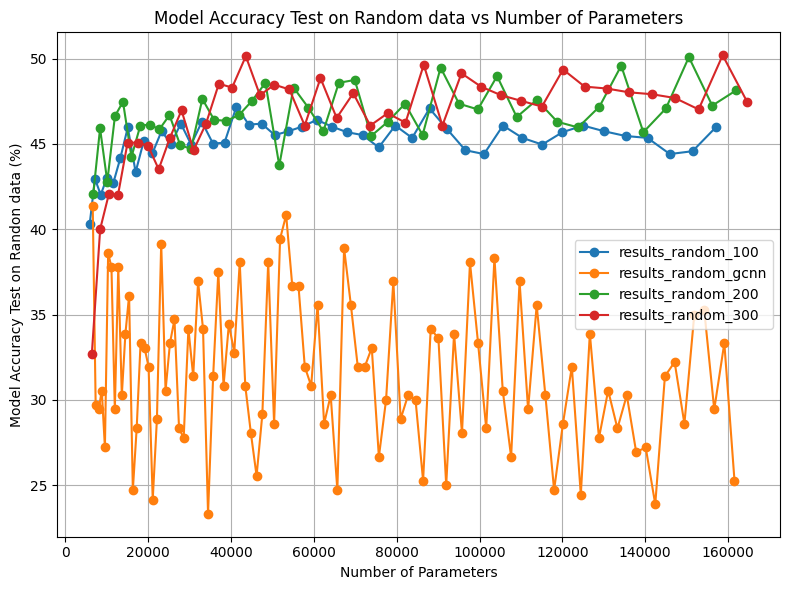

In [25]:
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt

zip_path = 'stored_data/results_random.zip'

dfs = {}
with zipfile.ZipFile(zip_path, 'r') as z:
    for fname in z.namelist():
        if fname.endswith('/'):
            continue
        content = z.read(fname).decode('utf-8')
        df = pd.read_csv(io.StringIO(content),
                         header=None,
                         names=['params', 'accuracy'])
        label = fname.rsplit('.', 1)[0]
        dfs[label] = df

plt.figure(figsize=(8, 6))
for label, df in dfs.items():
    plt.plot(df['params'],
             df['accuracy'],
             marker='o',
             linestyle='-',
             label=label)

plt.xlabel('Number of Parameters')
plt.ylabel('Model Accuracy Test on Randon data (%)')
plt.title('Model Accuracy Test on Random data vs Number of Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()